## Yolov5 from PyTorch
We will use a pre-trained Yolov5 model from PyTorch hub as a general vehicle detector that will feed detected vehicles to the emergency vehicle classifier we trained previously. PyTorch hosts this model via this Ultralytics github repo.

Model metadata:

- PyTorch hub name: yolov5s
- Pre-Training domain: MSCOCO
- Size: 14Mb
- Inference Speed on v100:
- pre-processing: 6.4ms
- inference 25ms
- total 31.4 ms
- .0314 seconds
- 37.2 mAP

Using cache found in /home/ubuntu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-1 Python-3.8.12 torch-1.10.0 CUDA:0 (Tesla V100-SXM2-16GB, 16161MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


image 1/3: 533x799 1 person, 6 cars, 1 truck, 2 traffic lights
image 2/3: 600x800 7 persons, 4 cars, 1 stop sign
image 3/3: 424x719 6 persons, 4 cars
Speed: 9.6ms pre-process, 19.0ms inference, 1.7ms NMS per image at shape (3, 3, 480, 640)


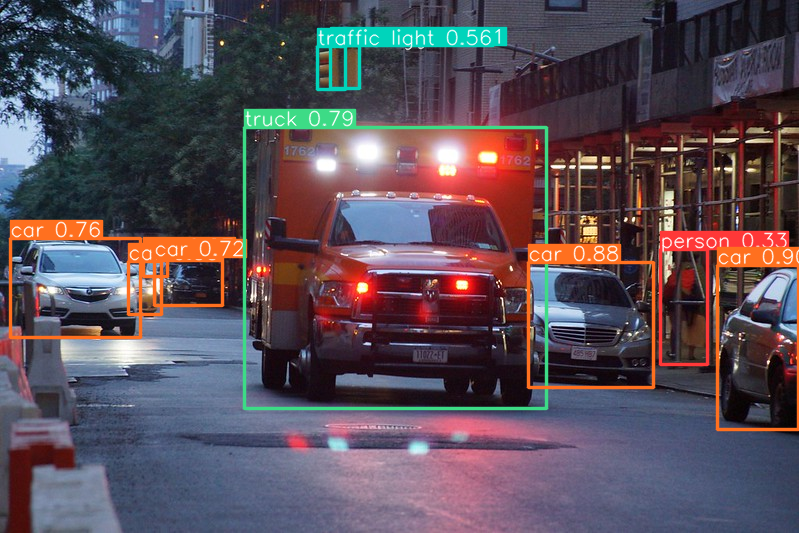

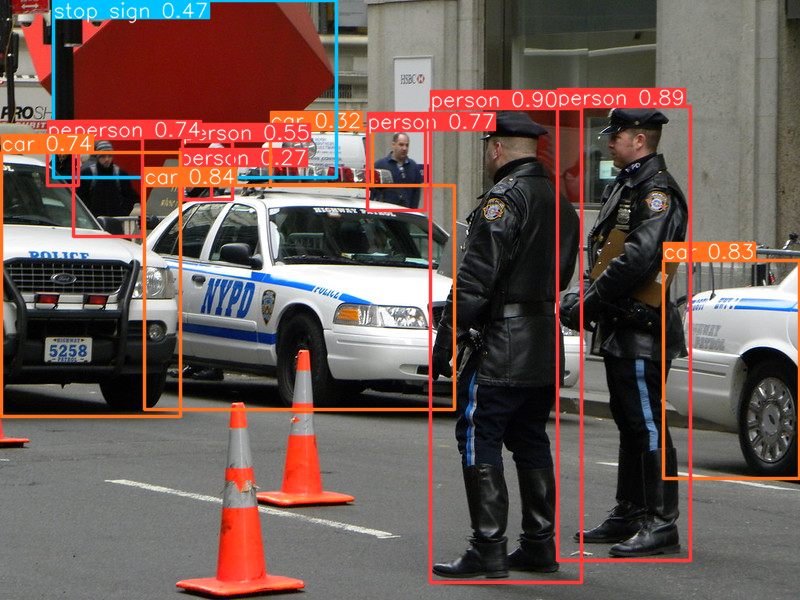

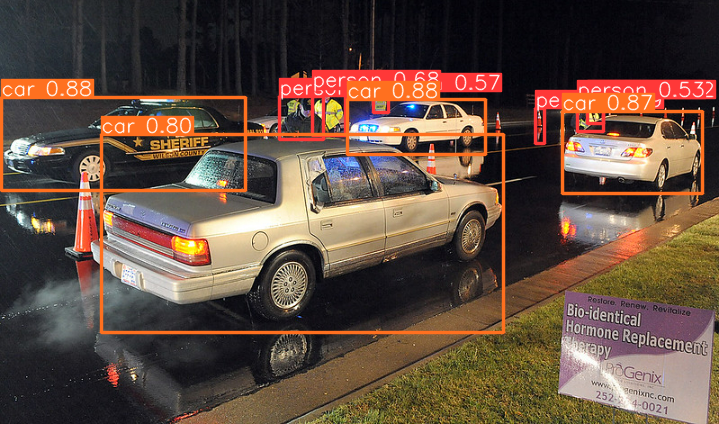

In [1]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Images
imgs = ['ambulance.jpg', 'nypd.jpg', 'night_sheriff.png']  # batch of images

# Inference
results = model(imgs)

# Results
results.print()
results.show()

## Image Chipping
We have a detector that finds vehicles and a classifier that determines whether they are an emergency vehicle or not. We need to feed the classifier images that are mostly composed on emergency vehicle pixels. To do this, we must pass an image through the detector, make image chips of each vehicle it detects, and feed those to the emergency vehicle classifier.

To do this, we need an easy way to extract the class names and locations of objects we are interested in.

In [42]:
im_idx = 0

results.xyxy[im_idx]  # img1 predictions (tensor)
results.pandas().xyxy[im_idx]  # img1 predictions (pandas)

,xmin,ymin,xmax,ymax,confidence,class,name
0,717.884399,265.421600,798.782593,429.153748,0.896519,2,car
1,528.135681,262.440063,653.841492,387.490692,0.879753,2,car
2,244.323730,127.427734,546.351257,408.955475,0.794515,7,truck
3,10.251766,238.040039,140.424240,337.556885,0.759590,2,car
4,154.606476,257.144043,222.018417,305.634369,0.722482,2,car
5,317.808594,46.340908,345.986877,89.259819,0.560348,9,traffic light
6,128.417603,261.956909,161.442230,314.859680,0.554196,2,car
7,330.604858,45.128723,359.771790,88.670074,0.512416,9,traffic light
8,660.545288,249.562469,707.622437,364.770142,0.327517,0,person
9,143.248505,255.189331,167.261154,276.837036,0.265011,2,car


## Filtering Results
We are only interested in classifying vehicles identified as `car` or `truck`. We can filter results to just those categories. The processing time for this dataframe is 52ms. We can move forward using pandas to process the results into a dataframe.

In [48]:
from time import process_time

start = process_time()
df = results.pandas().xyxy[im_idx]
df[df['class'].isin([2,7])]
end = process_time()

print('process time in seconds: ', end - start)
high_conf = df[df['confidence'] > .7]
np_data = high_conf[high_conf['class'].isin([2,7])].drop(['name', 'confidence', 'class'], axis=1).to_numpy().round()
print(np_data)

process time in seconds:  0.011199240999999915
[[        718         265         799         429]
 [        528         262         654         387]
 [        244         127         546         409]
 [         10         238         140         338]
 [        155         257         222         306]]


## Extracting Chips
We will round each of the estimated pixel locations in the results to use their coordinates in the original image. Using PyTorch's round() method automatically removes string data from consideration, which is nice. We are concerned with rows with 2 or 7 values which map to `car` and `truck`

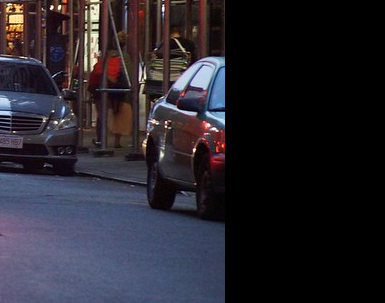

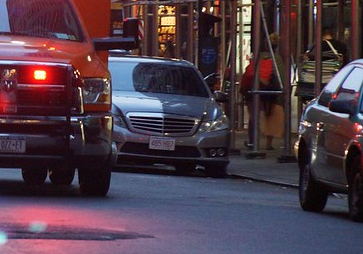

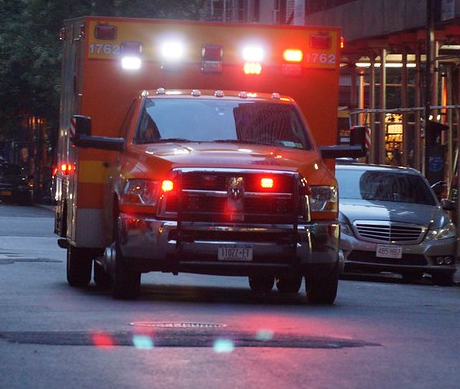

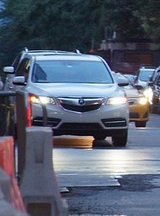

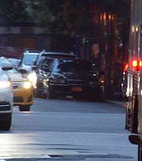

In [49]:
from PIL import Image
import numpy as np

img = Image.open(imgs[im_idx])

chips = []
# scaling the box size to improve results
scale = np.array([.80, .80, 1.20, 1.20])
for box in np_data:
    # widen box size by 30%
    box = box * scale
    cropped_im = img.crop(box)
    cropped_im.show()
    chips.append(cropped_im)

## Feeding images to Emergency Vehicle Classifier
Now we can try out the emergency vehicle classifier on these chips.

In [5]:
import torchvision


model = torchvision.models.mobilenet_v2(pretrained=False)
model.classifier = torch.nn.Linear(1280, 1)

mod_1 = './emergency_vehicle_1_mobilenetv2.pth'
mod_2 = './emergency_vehicle_2_mobilenetv2.pth'

model.load_state_dict(torch.load(mod_2))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

## Model Performance on Image Chips
### Chip Pre-processing
We apply the same image transformations as we did during validation during training.

In [6]:
from torchvision import transforms as T


def data_transformers(split:str):
    # using ImageNet mean and standard deviations to normalize images
    mu = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # training images will be randomly cropped and horizontally flipped
    # validation images will only be normalized
    data_transforms = {'train': T.Compose([
        T.RandomResizedCrop(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(), # image is scaled to [0-1]
        T.Normalize(mu, std)
        ]),
        'val': T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mu, std)
        ])}
    return data_transforms[split]

val_trans = data_transformers('val')

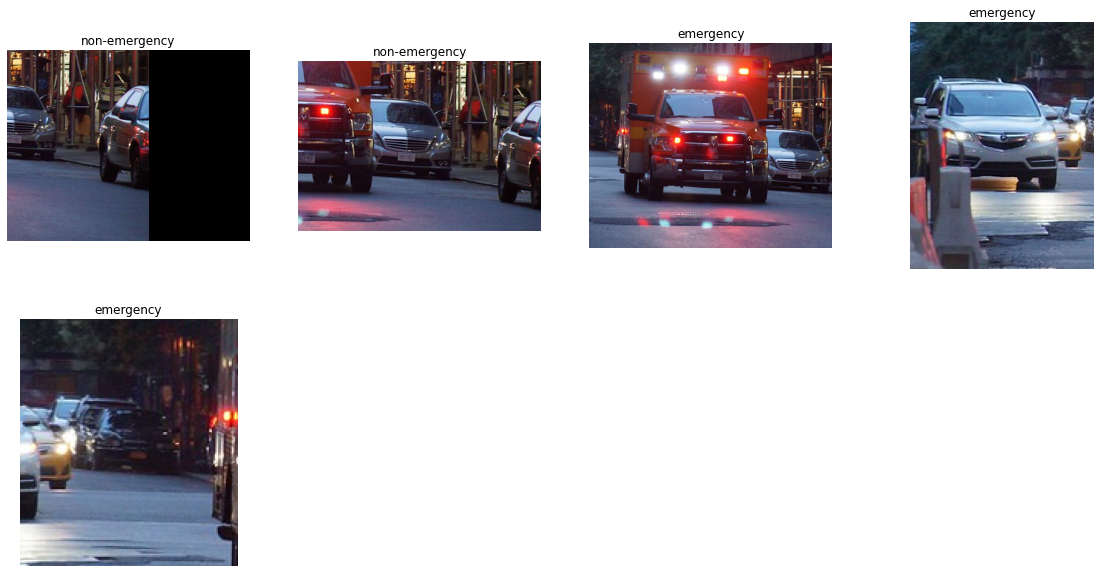

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

label_map = {0:'emergency', 1:'non-emergency'}
outputs = []
plt.figure(figsize=(20,10))
for idx, img in enumerate(chips):
    input = val_trans(img)
    logit = model(input.unsqueeze(0))
    pred = torch.clip(logit, 0, 1)
    outputs.append(pred)
    plt.subplot(2,4, idx +1)
    plt.imshow(img)
    plt.title(label_map[int(pred.detach().numpy())])
    plt.axis('off')
plt.show()

| image | correct | wrong |
|--|--|--|
| img 0 | 2 | 5 |
| img 2 | 4 | 0 |
| img 3 | 3 | 1 |

In [37]:
9 / 15

0.6